# Assimilat GLSD data with DIESEL

This notebook runs assimilation of GLSD data using the DIESEL version of the Ensemble Kalman filter. 

It also compares two assimilation methods (normal vs cell-averaged observations).

In [1]:
import os
import numpy as np
import dask
import pandas as pd
import dask.array as da
import xarray as xr
from climate.utils import load_dataset

from dask.distributed import Client, wait, progress                             
import diesel as ds                                                             
from diesel.scoring import compute_RE_score, compute_CRPS, compute_energy_score 
from diesel.estimation import localize_covariance 

/storage/homefs/ct19x463/.conda/envs/climate/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
base_folder = "/storage/homefs/ct19x463/Dev/Climate/Data/"
results_folder = "/storage/homefs/ct19x463/Dev/Climate/reporting/glsd_assimilation_diesel"

## Build Cluster

In [3]:
cluster = ds.cluster.UbelixCluster(n_nodes=12, mem_per_node=64, cores_per_node=3,
            partition="gpu", qos="job_gpu")                                     
cluster.scale(10)                                                           
client = Client(cluster)                                                    
                                                                                
# Add to builtins so we have one global client.
# Note that this is necessary before importing the EnsembleKalmanFilter module, so that the module is aware of the cluster.
__builtins__.CLIENT = client                                                

In [4]:
from diesel.kalman_filtering import EnsembleKalmanFilter 
from dask.diagnostics import ProgressBar
ProgressBar().register()

In [5]:
cluster

In [6]:
TOT_ENSEMBLES_NUMBER = 30
(dataset_mean, dataset_members,
    dataset_instrumental, dataset_reference,
    dataset_members_zarr)= load_dataset(
    base_folder, TOT_ENSEMBLES_NUMBER, ignore_members=True)
print("Loading done.")

/storage/homefs/ct19x463/.conda/envs/climate/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/storage/homefs/ct19x463/Dev/Climate/climate/utils.py:144: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, '360_day', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  dataset_mean['time'] = dataset_mean.indexes['time'].to_datetimeindex()
/storage/homefs/ct19x463/Dev/Climate/climate/utils.py:145: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, '360_day', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  dataset_members['time'] = dataset_members.ind

Loading done.


In [7]:
from climate.kalman_filter import EnsembleKalmanFilterScatter
helper_filter = EnsembleKalmanFilterScatter(dataset_mean, dataset_members_zarr, dataset_instrumental, client)

Maximal distance to matched point: 120.54565778878536 km.


## Prepare vectors.

In [8]:
assimilation_date = '1961-01-16'
mean_ds = helper_filter.dataset_mean.get_window_vector(assimilation_date, assimilation_date, variable='temperature')
ensemble_ds = helper_filter.dataset_members.get_window_vector(assimilation_date, assimilation_date, variable='temperature')

In [9]:
mean_ds, ensemble_ds = client.persist(mean_ds), client.persist(ensemble_ds)

## Load Data

In [10]:
year = 1961
data_df = pd.read_csv(os.path.join(base_folder, "Instrumental/GLSD/yearly_csv/temperature_{}.csv".format(year)), index_col=0)
data_ds = xr.Dataset.from_dataframe(data_df)

# Rename the date variable and make latitude/longitude into coordinates.
data_ds = data_ds.rename({'date': 'time'})
data_ds = data_ds.set_coords(['time', 'latitude', 'longitude'])
data_ds = data_ds['temperature']

## Prepare Forward Operator

In [11]:
# Select one month.
date= '1961-01-01'
data_month_ds = data_ds.where(data_ds.time==date, drop=True)

# Need to clean data since dataset contains erroneous measurements, i.e. 
# either extreme values (10^30) or values that are exactly zero for a given station across time.
data_month_ds = data_month_ds.where((data_month_ds > -100.0) & (data_month_ds < 100.0) & (da.abs(data_month_ds) > 0.0001), drop=True)

In [12]:
# Get the model cell index corresponding to each observations.
from climate.utils import match_vectors_indices
matched_inds = match_vectors_indices(mean_ds, data_month_ds)

# WARNING: Never try to execute bare loops in DASK, it will exceed the maximal graph depth.
G = np.zeros((data_month_ds.shape[0], mean_ds.shape[0]))
for obs_nr, model_cell_ind in enumerate(matched_inds):
    G[obs_nr, model_cell_ind] = 1.0

G = da.from_array(G)
G = client.persist(G)

Maximal distance to matched point: 159.00847229868702 km.


## (Deprecated) Make Filter more stable by only assimilating mean for model cells that contain multiple observations.

The idea here is that having multiple (in this case around 50) observations being assimilated in a single model cell can lead to numerical instabilities. 
We thus work with one observations per cell, being the mean of all the observations. 
In the end the idea was abandoned, since it only plays a role for the updating of the ensemble members. For the mean everything works.

In [13]:
obs_per_cell = da.sum(G, axis=0)
obs_per_cell[obs_per_cell == 0] = 1
G_norm = G / obs_per_cell
G_norm = client.persist(G_norm)

In [14]:
# The operator G_avg contains one single observation per model cell (or zero), which is the average of all observations belonging to that cell.
averaged_data = (G_norm.T @ data_month_ds.values).T.compute()
G_avg = da.eye(averaged_data.shape[0])
G_avg = G_avg[np.flatnonzero(averaged_data), :]
d_avg = averaged_data[np.flatnonzero(averaged_data)]

## Estimate Covariance 

In [15]:
 # Estimate covariance using empirical covariance of the ensemble.       
raw_estimated_cov_lazy = ds.estimation.empirical_covariance(ensemble_ds.chunk((1, 1800)))  
                                                                                
# Persist the covariance on the cluster.                                
raw_estimated_cov = client.persist(raw_estimated_cov_lazy) 
progress(raw_estimated_cov)

/storage/homefs/ct19x463/.conda/envs/climate/lib/python3.8/site-packages/dask/array/routines.py:328: PerformanceWarning: Increasing number of chunks by factor of 11
  intermediate = blockwise(


VBox()

In [16]:
# Construct (lazy) covariance matrix.                                       
lambda0 = 1500 # Localization in kilometers.

lengthscales = da.from_array([lambda0])   
kernel = ds.covariance.squared_exponential(lengthscales)

In [19]:
# Perform covariance localization.
grid_pts = da.vstack([mean_ds.latitude, mean_ds.longitude]).T
grid_pts = client.persist(grid_pts.rechunk((1800, 2)))
localization_matrix = kernel.covariance_matrix(grid_pts, grid_pts, metric='haversine') 
localization_matrix = client.persist(localization_matrix)
progress(localization_matrix)

/storage/homefs/ct19x463/.conda/envs/climate/lib/python3.8/site-packages/dask/array/blockwise.py:288: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")
/storage/homefs/ct19x463/.conda/envs/climate/lib/python3.8/site-packages/dask/array/blockwise.py:289: PerformanceWarning: Increasing number of chunks by factor of 11
  return blockwise(*args, **kwargs)


VBox()

In [20]:
# TODO: Here we have added multiplicative inflation.
loc_estimated_cov = localize_covariance(raw_estimated_cov, localization_matrix)
loc_estimated_cov = client.persist(loc_estimated_cov)
progress(loc_estimated_cov)

VBox()

## Plot Localized Covariance

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


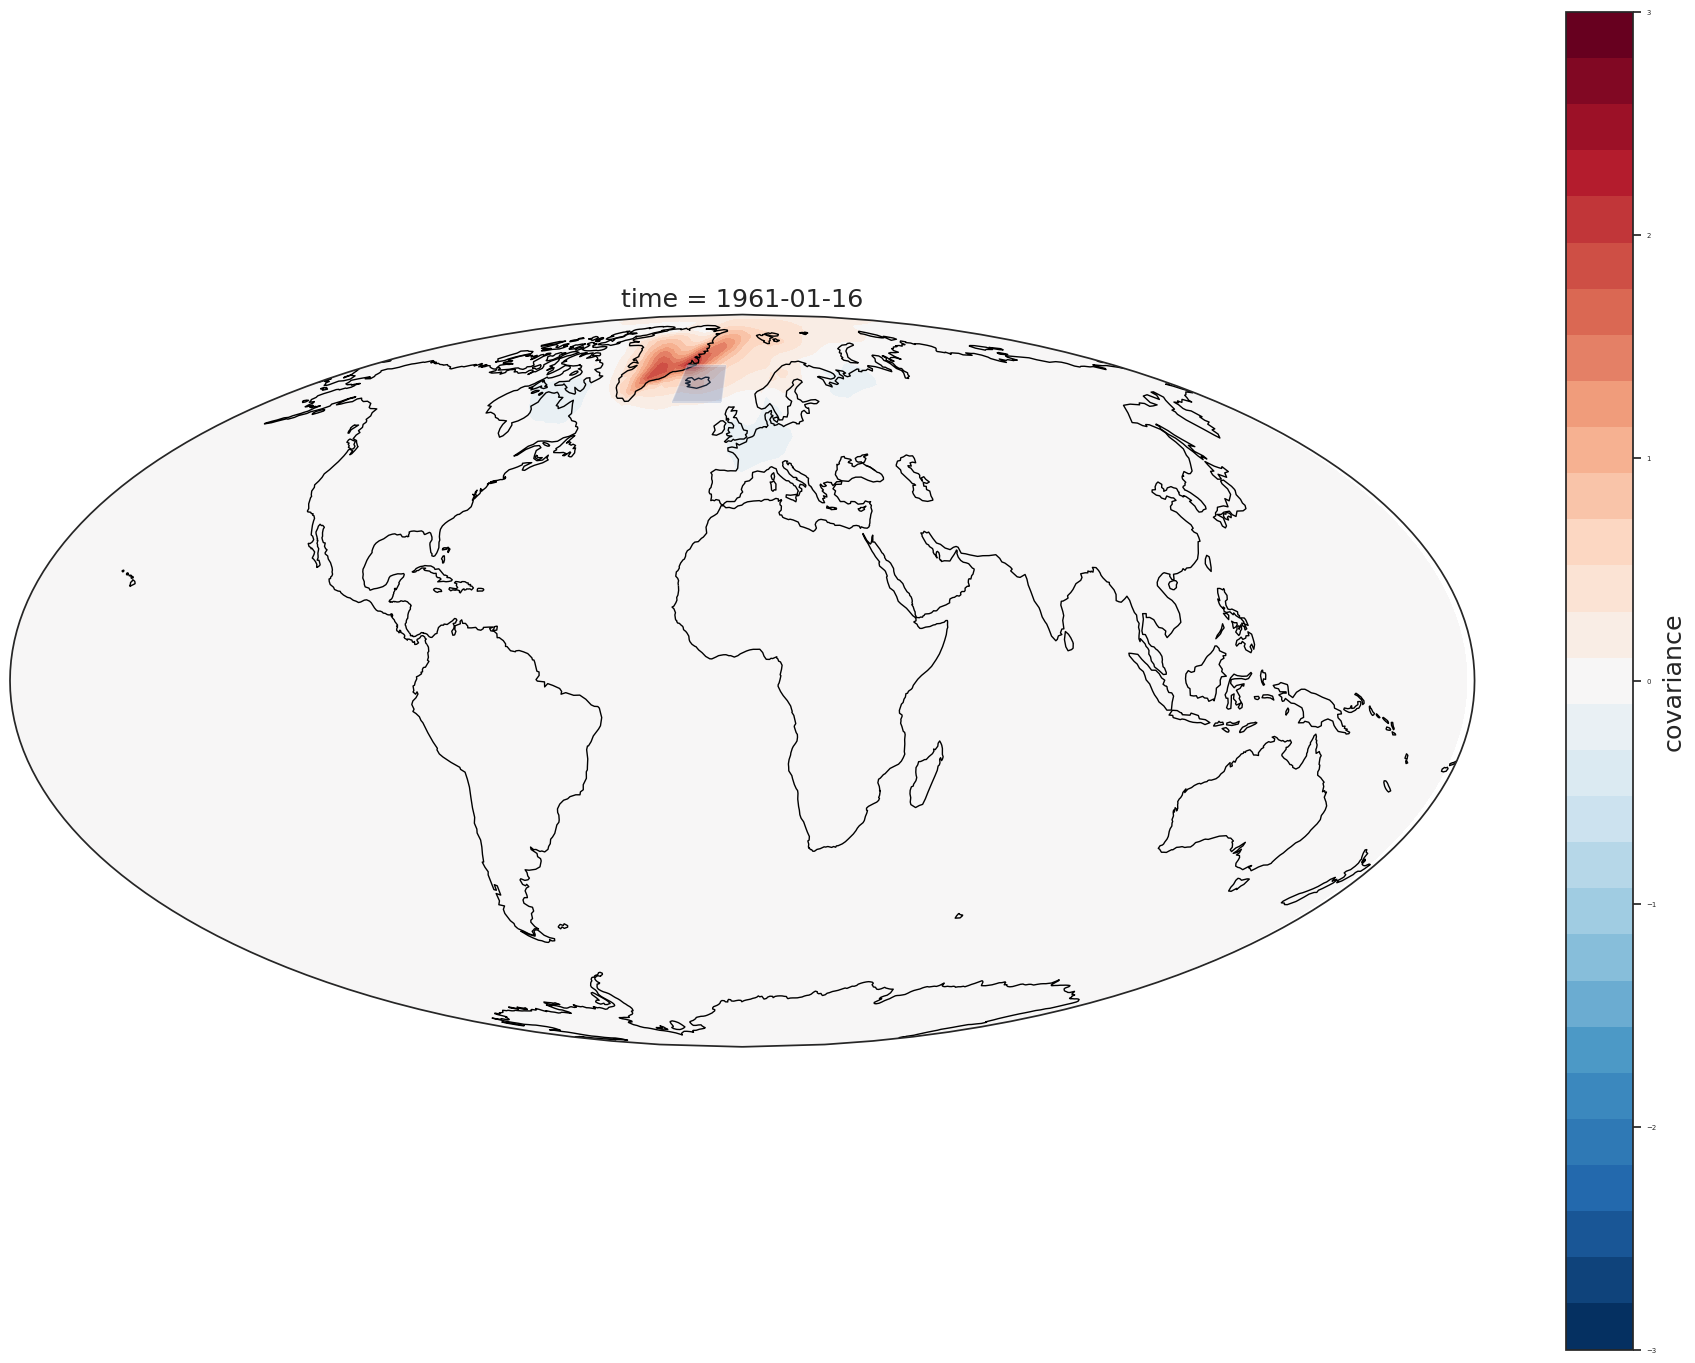

In [24]:
# Get indices for Iceland.
flat_inds_Iceland = helper_filter.dataset_members.get_region_flat_inds(lat_min=60, lat_max=70, lon_min=-27, lon_max=-8)   
cov_Iceland = loc_estimated_cov[flat_inds_Iceland, :].mean(axis=0)
cov_Iceland_computed = client.compute(cov_Iceland).result()
unstacked = helper_filter.dataset_mean.unstack_window_vector(cov_Iceland_computed, time='1961-01-16', variable_name='covariance')


%matplotlib inline 
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.dpi'] = 100

import cartopy.crs as ccrs
from shapely import geometry


def plot_covariance_map(covariance_map, outfile):
    cm = 1/2.54  # centimeters in inches
    fig = plt.figure(figsize=(60*cm, 45*cm))
    ax = plt.axes(projection=ccrs.Mollweide())
    # ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.set_global()
    covariance_map.covariance.plot.contourf(levels=30, ax=ax, transform=ccrs.PlateCarree(),
                                vmin=-3, vmax=3, cmap='RdBu_r',
                               cbar_kwargs={'ticks': [-3, -2, -1, 0, 1, 2, 3],
                                           'label': 'covariance'})
    ax.coastlines()    

    # Add bounding box around Iceland.
    lat_min=60
    lat_max=70
    lon_min=-27
    lon_max=-8
    geom = geometry.box(minx=lon_min,maxx=lon_max,miny=lat_min,maxy=lat_max)
    ax.add_geometries([geom], crs=ccrs.PlateCarree(), alpha=0.3)
    plt.savefig(outfile, bbox_inches='tight', dpi=120)

def plot(unstacked_data, outfile=None, vmin=None, vmax=None):
    cm = 1/2.54  # centimeters in inches
    fig = plt.figure(figsize=(40*cm, 25*cm))
    ax = plt.axes(projection=ccrs.Mollweide())
    # ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.set_global()
    unstacked_data.plot.contourf(levels=30, ax=ax, transform=ccrs.PlateCarree(),
                                vmin=vmin, vmax=vmax, cmap='RdBu_r',
                               cbar_kwargs={'ticks': [-30, -20, -10, 0, 10, 20, 30],
                                           'label': 'temperature'})
    ax.coastlines()    
    if outfile is not None: plt.savefig(outfile, bbox_inches='tight', dpi=120)

plot_covariance_map(unstacked, "test.png")

# Run Assimilation

In [25]:
 # Run data assimilation using an ensemble Kalman filter.                
my_filter = EnsembleKalmanFilter()                                      

data_std = 0.1
data_vector = client.persist(da.from_array(data_month_ds.data))

# Assimilate all data.
mean_updated, ensemble_updated = my_filter.update_ensemble(
    mean_ds.data, ensemble_ds.data, G,
    data_vector, data_std, loc_estimated_cov)
"""
# Assimilate reduced (averaged) dataset.
mean_updated_one_go_loc_reduced, ensemble_updated_one_go_loc = my_filter.update_ensemble(
    mean_ds.data, ensemble_ds.data, G_avg,
    d_avg, data_std, loc_estimated_cov)
"""
# Trigger computations and block. Otherwise will clutter the scheduler. 
mean_updated = client.persist(mean_updated)                
# ensemble_updated_one_go_loc = client.persist(ensemble_updated_one_go_loc)
progress(mean_updated) # Block till end of computations.                               

/storage/homefs/ct19x463/.conda/envs/climate/lib/python3.8/site-packages/dask/array/core.py:4796: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/storage/homefs/ct19x463/.conda/envs/climate/lib/python3.8/site-packages/dask/array/routines.py:446: PerformanceWarning: Increasing number of chunks by factor of 11
  out = blockwise(


VBox()

In [26]:
# Save results.
np.save(os.path.join(                                                   
        results_folder, "mean_updated.npy"),      
        mean_updated.compute())

## Compare the different updates.

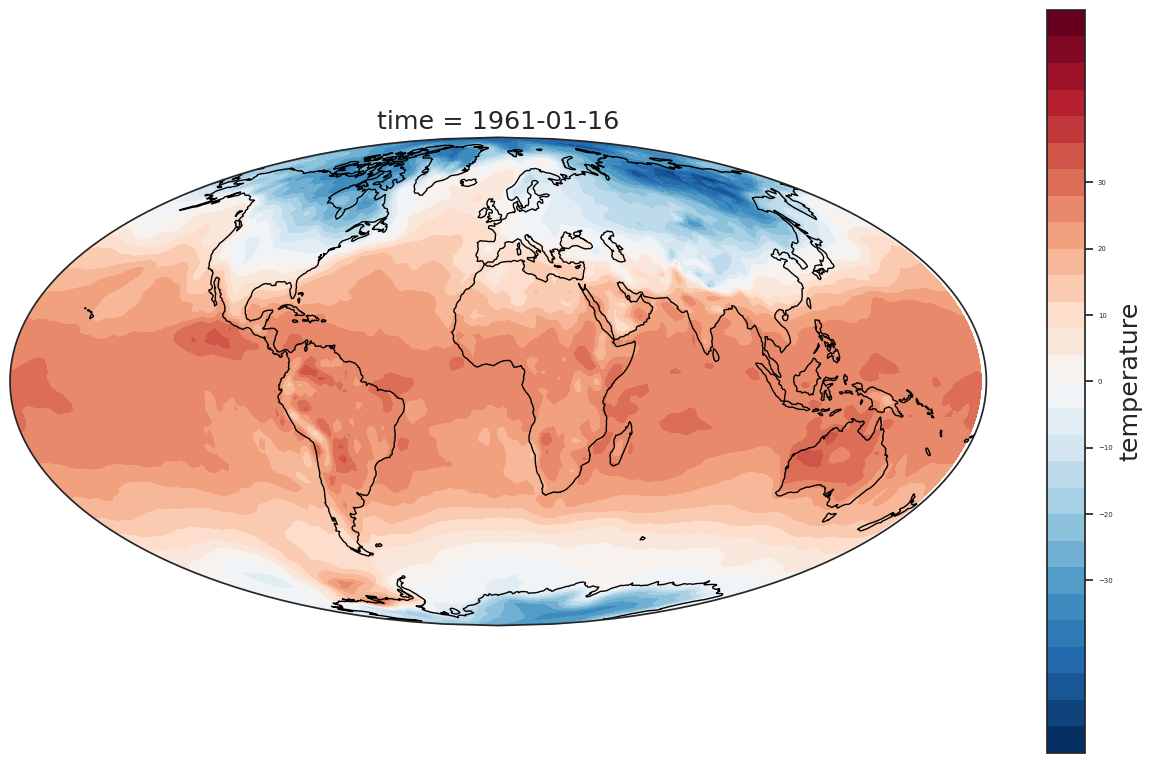

In [30]:
unstacked_updated_mean = helper_filter.dataset_mean.unstack_window_vector(mean_updated.compute(), time='1961-01-16', variable_name='temperature', vmin=-40, vmax=40)
plot(unstacked_updated_mean.temperature)

In [ ]:
unstacked_updated_mean_avg = helper_filter.dataset_mean.unstack_window_vector(mean_updated_avg.compute(), time='1961-01-16', variable_name='temperature', vmin=-40, vmax=40)
plot(unstacked_updated_mean_avg.temperature)

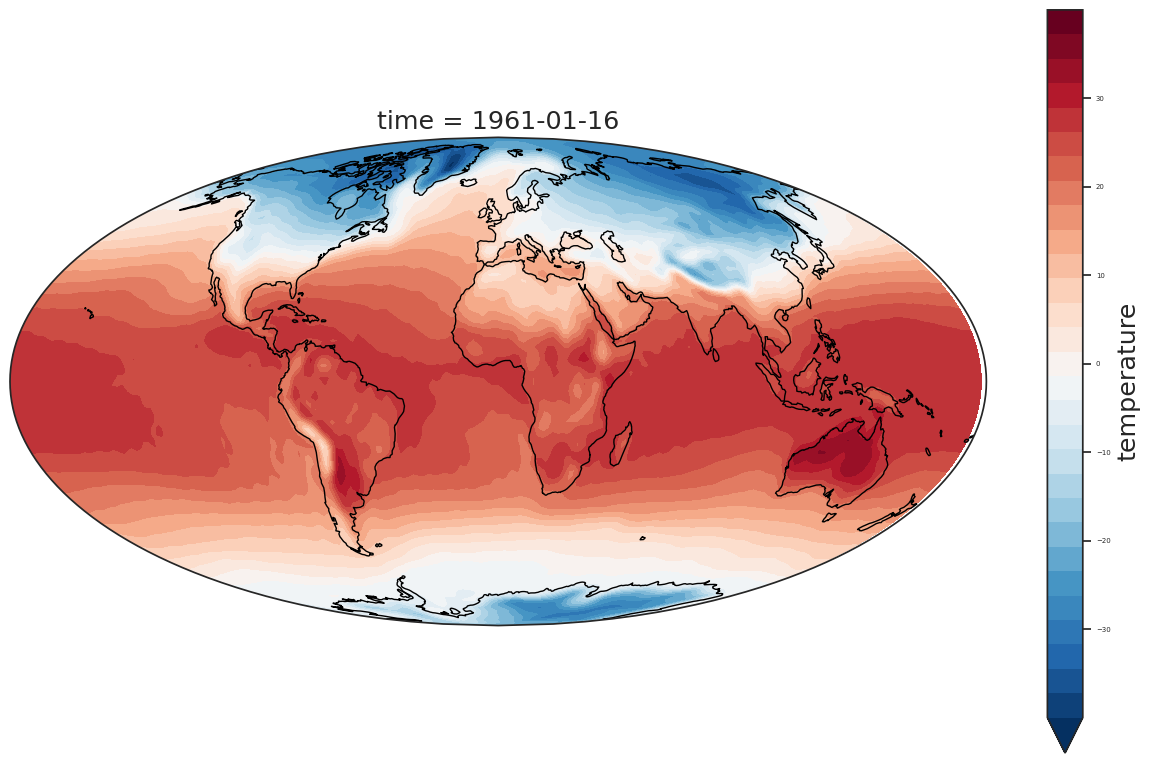

In [37]:
# Plot original data (before updating.
unstacked_mean = helper_filter.dataset_mean.unstack_window_vector(mean_ds.values.reshape(-1), time='1961-01-16', variable_name='temperature')
plot(unstacked_mean.temperature, vmin=-40, vmax=40)

<GeoAxesSubplot:xlabel='longitude', ylabel='latitude'>

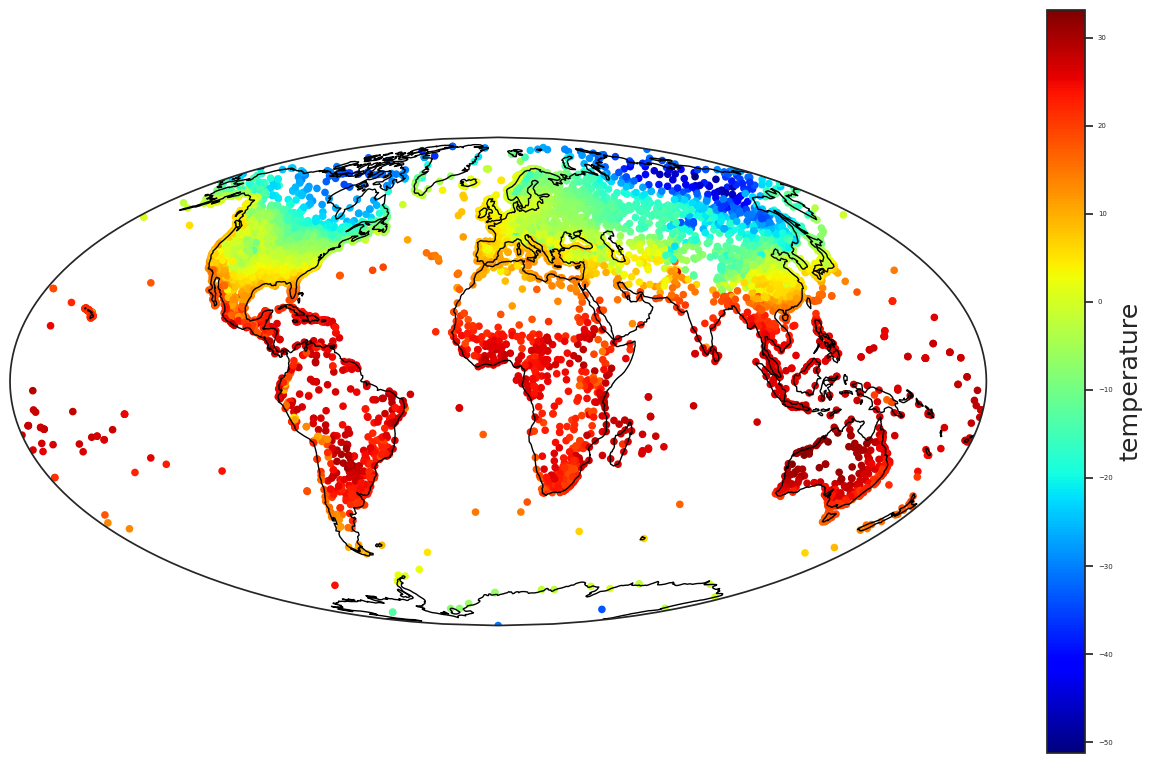

In [32]:
# Plot station data.
df = data_month_ds.to_dataframe()
# Could reset coordinates if you really wanted
# df = df.reset_index()
cm = 1/2.54  # centimeters in inches
fig = plt.figure(figsize=(40*cm, 25*cm))
ax = plt.axes(projection=ccrs.Mollweide())
ax.set_global()
    
ax.coastlines()  

df.plot.scatter('longitude', 'latitude', c=data_month_ds.name, cmap='jet', ax=ax, transform=ccrs.PlateCarree())

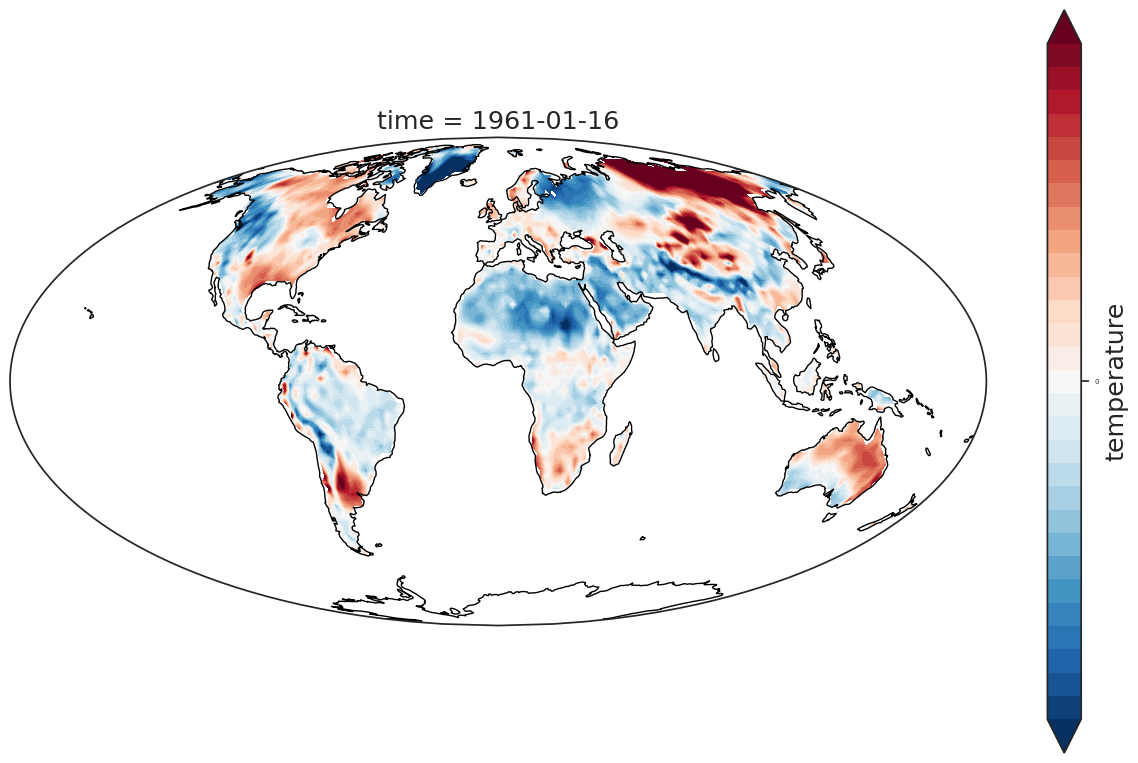

In [39]:
# Plot error wrt reference.
plot(unstacked_updated_mean.temperature - dataset_reference.temperature.sel(time='1961-01-16'), vmin=-7, vmax=7)

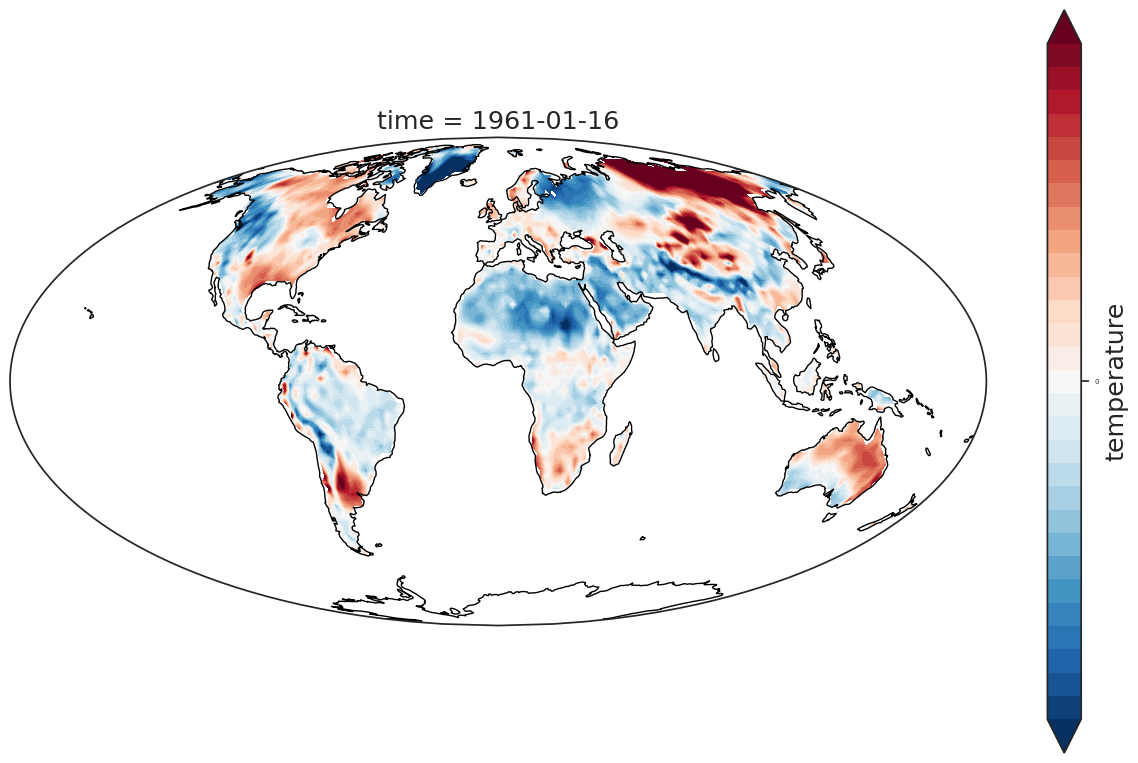

In [38]:
# Plot original error.
plot(unstacked_mean.temperature - dataset_reference.temperature.sel(time='1961-01-16'), vmin=-7, vmax=7)